# A Bayesian Approach of Coin Tosses

This notebook dives into the specifics of Bayesian inference. It's not essential to complete the General Assembly course, but it's recommended to study if you're seriously interested in a data science career.

###Coin flips

Suppose I flip a coin five times, and I get the following result:

    H T H H T

According to **frequentist statistics** (which is the classical method), you would estimate the probability of tossing head by

$$P(H|\text{ tosses}) = \frac{n}{N},$$

where $n$ of the number of heads and $N$ the number of total tosses. The left hand side term means, given the observed tosses, what is the probability of tossing a head? Hence, in this case, we would estimate that $P(H) = 3/5$. Obviously, you would need a lot of tosses before you are comfortable before making an estimation.

In **Bayesian statistics**, however, you would incorporate your prior belief into this estimation. A big advantage of that is that you'd have a comfortable estimation sooner, assuming you'd trust your prior blieves. Also, you would not estimate the probability $P(H)$ of throwing a head directly, but rather indirectly. You'd ask yourself, given the observed tosses, what is the chance that this probability $P(H)$ is equal to some value $p$? You would then mine different values for $p$ to see which value is the most likely.

$$P({P(H) = p}|\text{ tosses}) = \frac{P(\text{tosses }|H) \times P(P(H) = p)}{P(\text{tosses})}$$

So the Bayesian way will not only offer you a point estimate of the probability $P(H)$, but also provide you with a full probability distribution for each possible $p$.

Let's demonstrate these boths methods for a simulated series of coin flips.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

### Ground truth

Let's simulate a series of coin tosses, for some fixed probability $p$ of throwing heads. We simulate an _unfair_ coin, which is more likely to fall one particular side (so $p\neq .5$)

In [2]:
p = .6  # probability of head (vs. tail) - note that if p ≠ .5, this coin is unfair
N = 30  # number of coin tosses
tosses = np.random.random(N) < p  # uniform distribution
print " ".join(list("TH")[toss] for toss in tosses)

T T T T H H T T H H H T T T T H H T H H T H H H T T H H T T


The above is our observed series of coin tosses.

Let's compute some basic statistics.

In [3]:
print p * N  # expected value of # of heads
print tosses.sum()  # observed # of heads
print tosses.mean()  # probability estimation of flipping a head, the frequentist way

18.0
14
0.466666666667


### Frequentist way

Let's compute the probability of throwing head in the classical way.

In [4]:
def frequentist(tosses):
    return tosses.mean()

In [5]:
frequentist(tosses)

0.46666666666666667

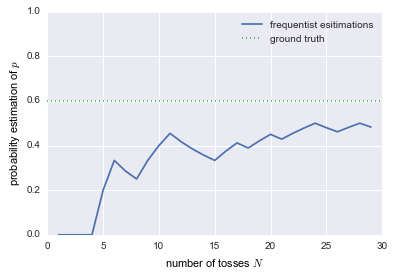

In [6]:
freq = [frequentist(tosses[:n]) for n in xrange(1, N)]
f = plt.plot(range(1, N), freq, label="frequentist esitimations")
f = plt.plot([0, N], [p, p], ":", label="ground truth")
f = plt.legend(), plt.ylim(0, 1)
f = plt.xlabel("number of tosses $N$"), plt.ylabel("probability estimation of $p$")

You see that the esitmations get better as the number of tosses increases. It's rather bad in the very beginning. In particular, at $N=0$, we have no idea.

### Bayesian way

Let's compute the probability of throwing head in the bayesian way.

For readability's sake, let's simply write $P(p)$ for $P(P(H) = p)$ and  $P(D)$ for $P(\text{tosses})$ (using the $D$ for Data).

$$P(p|D) = \frac{P(D|p) \times P(p)}{P(D)}$$

So this reads: given our data $D$, i.e., our observed coin tosses, what is the probability that $P(H)$ is $p$? 

Since we're interested in which $p$ will give us the _maximum a posteriori likelihood (MAP)_ estimate, we can drop the denominator since the factor $P(D)$ does not depend on $p$.

$$\max_p P(p|D) = \max_p P(D|p) P(p) $$

Working with products of probabilities gets very tedious as the numbers get too small to be suitable for computing. We often take the logarithm of both sides, so the computations get easier. This won't change the maximum $p$.

$$\max_p \log P(p|D) = \max_p \big(\log P(D|p) + \log P(p) \big)$$

So we'll need a **prior** belief for $p$. This is always a very subjective step. If you have absolutely no idea, you could take the uniform distribution in this case, but you probably feel as well that the limit cases $p=0$ and $p=1$ are very unlikely for a coin toss – or even impossible. So we will pick some Beta distribution:

$$P(p) = 6p(1-p)$$.

Note that $P(p) = 0$ for $p = 0$ or $1$. The constant 6 is to make the area under the curve equal to one. Also note that this distribution is _symmetric_, so we believe it's most likely that the coin is fair. Obviously, if we have different prior believes, we could change all of that.

In [7]:
def prior(p):
    """What is the prior probability that P(head) == p?"""
    return 6 * p * (1 - p) 

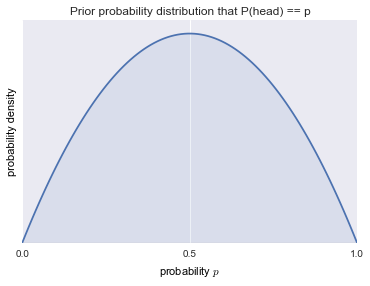

In [8]:
x = np.linspace(0, 1, 100)
f = plt.plot(x, prior(x))
f = plt.fill_between(x, prior(x), 0, alpha=.1)
f = plt.title("Prior probability distribution that P(head) == p")
f = plt.xlabel("probability $p$"), plt.ylabel("probability density"), plt.xticks([0, .5, 1]), plt.yticks([])

We also need the **likelihood** function $P(D|p)$. This is the reversed question: given any probability $p$, what is the chance I'd see the observed coin tosses $D$? It depends on how we represent $D$ what this function is, i.e., are we just counting the number of heads, or are we maintaining the order of the heads and tails? Let's say the precise order does not matter, then we'd have the Binomial distribution:

$$P(D|p) = {N\choose n} p^n (1-p)^{N-n},$$
where $n$ is the number of heads thrown, and $N$ is the total number of throwns. If we would care about order, we would drop the ${N\choose n}$ part. For the eventual Bayesian results, this choice does not matter.

It follows that the _log likelihood_ is equal to

$$\log P(D|p) = \log {N\choose n} + n \log p + (N-n) \log (1-p).$$

Combining the likelihood with the prior function, we get the following formula. Note that we're interested in finding the maximum $p$, so we can drop all constants again.

$$\begin{equation} 
\begin{split}
\max_p \log P(p|D) 
&= \max_p \big(n \log p + (N-n) \log (1-p) + \log p + \log (1-p)\big) \\
&= \max_p \big((n+1) \log p + (N-n+1) \log (1-p) \big)
\end{split}
\end{equation}$$

Note that this has a maximum if its derivate to $p$ is zero:
$$\begin{equation} 
\begin{split}
\frac{d}{dp} \log P(p|D) &=  0 \\
\frac{n+1}{p} + \frac{N-n+1}{1-p} &= 0 \\
p = \frac{n+1}{N+2}
\end{split}
\end{equation}$$


That's it! According to Bayes, the probability of throwing a head is equal to $p = \frac{n+1}{N+2}$, where $n$ of the number of heads and $N$ the number of total tosses. You could interpret this as being equivalent to the classical approach, after having added two additional coin flips at the beginning: we count one more head, and one more tail than we would otherwise have counted.

    [H T] H T H H T

As a side remark, note that in this starightforward example it wasn't necessary to take the log of both sides. We still did so, however, since it is a very common step in most Bayesian estimations, so having seen it already would make you better prepared. Also, in our further analysis, we'll use these functions to estimate the distributions.

In [9]:
def bayesian(tosses):
    n_heads = tosses.sum()
    n_tails = len(tosses) - n_heads
    return (n_heads + 1) / float(n_heads + n_tails + 2)

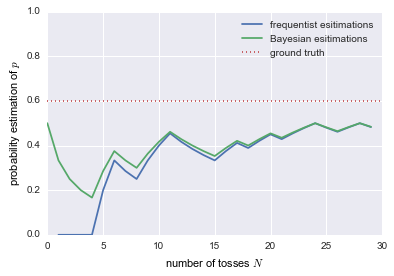

In [10]:
bayes = [bayesian(tosses[:n]) for n in xrange(N)]
f = plt.plot(range(1, N), freq, label="frequentist esitimations")
f = plt.plot(range(0, N), bayes, label="Bayesian esitimations")
f = plt.plot([0, N], [p, p], ":", label="ground truth")
f = plt.legend(), plt.ylim(0, 1)
f = plt.xlabel("number of tosses $N$"), plt.ylabel("probability estimation of $p$")

Note that Bayes, in comparison to the frequentist way,
- starts at zero tosses already, with $p=5$, which is our prior belief;
- starts off much less volatile, and more realistic, due to our reasoable prior belief;
- stays a tiny bit closer to the prior, and here the ground truth, for a larger number of tosses.

These are all advantages if you build a real-time algorithm that needs to operate from day one, when there's no data available yet.

### Posterior distributions

As mentioned earlier, Bayes does not only provide a point estimate for $p$, but a full likelihood distribution as well. Let's plot some a posteriori likelihood distributions for some number of coin tosses $N$.

In [11]:
def log_prior(p):
    """What is the prior probability that P(head) == p?"""
    return np.log(p) + np.log(1 - p) 

def log_likelihood(p, tosses=tosses):
    """What is the likelihood that that P(head) == p, given the observed data?"""
    return np.log(tosses * p + (1 - tosses) * (1 - p)).sum()

def log_posterior(p, tosses=tosses):
    """What is the a posteriori likelihood that that P(head) == p, given the prior and the data?"""
    return log_likelihood(p, tosses) + log_prior(p)

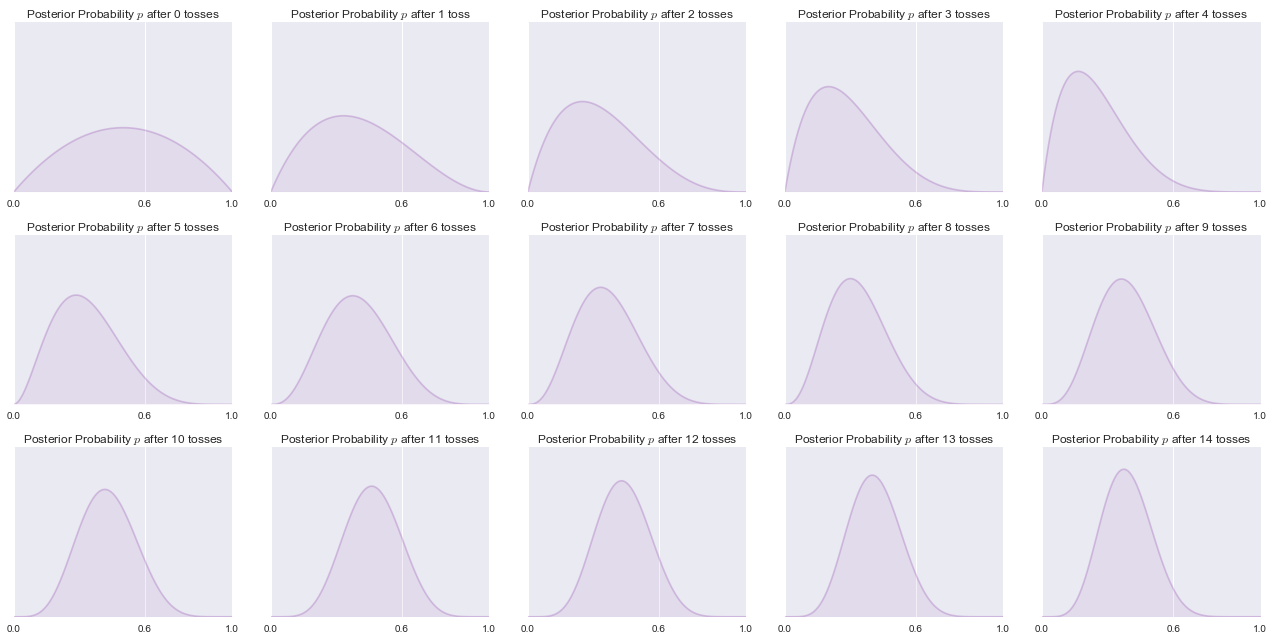

In [12]:
n_rows = 3
fig, axes = plt.subplots(n_rows, 5, figsize=(18, 3 * n_rows))
# x = np.linspace(0, 1, 100)
for k in xrange(n_rows * 5):
    y = np.exp(np.array([log_posterior(q, tosses=tosses[:k]) for q in x]))
    y = y / y.sum() * len(x)  # normalize, so that area under the curve is one again
    axes[k / 5, k % 5].set_title("Posterior Probability $p$ after %d toss%s" % (k, ["es", ""][k == 1]))
    axes[k / 5, k % 5].plot(x, y, c="#9b59b6", alpha=.3, label=k)
    axes[k / 5, k % 5].fill_between(x, y, -0, color="#9b59b6", alpha=.1)
    axes[k / 5, k % 5].set_ylim(0, 4), axes[k / 5, k % 5].set_xticks([0, p, 1]), axes[k / 5, k % 5].set_yticks([])
f = plt.tight_layout()

As you can see, 
- the curve for $N=0$ is exactly our prior belief,
- the top of the curve moves to $p$, albeit not straight (but following the graph we saw earlier),
- the standard deviation gets smaller as $N$ increases, meaning we get more and more confident about our estimations.

###Likelihood distributions

We can also look at the likelihood distributions, which denote the likelihood of the data given some $p$, and which does not account for our prior belief.

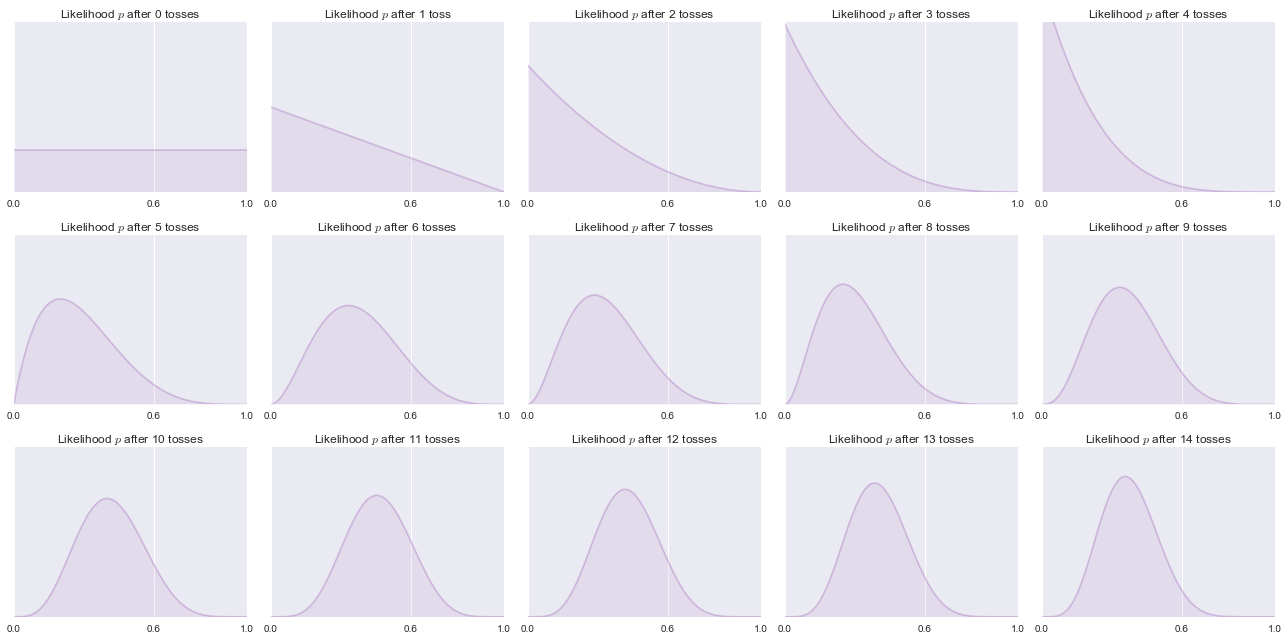

In [13]:
n_rows = 3
fig, axes = plt.subplots(n_rows, 5, figsize=(18, 3 * n_rows))
# x = np.linspace(0, 1, 100)
for k in xrange(n_rows * 5):
    y = np.exp(np.array([log_likelihood(q, tosses=tosses[:k]) for q in x]))
    y = y / y.sum() * len(x)  # normalize, so that area under the curve is one again
    axes[k / 5, k % 5].set_title("Likelihood $p$ after %d toss%s" % (k, ["es", ""][k == 1]))
    axes[k / 5, k % 5].plot(x, y, c="#9b59b6", alpha=.3, label=k)
    axes[k / 5, k % 5].fill_between(x, y, -0, color="#9b59b6", alpha=.1)
    axes[k / 5, k % 5].set_ylim(0, 4), axes[k / 5, k % 5].set_xticks([0, p, 1]), axes[k / 5, k % 5].set_yticks([])
f = plt.tight_layout()

As you can see, 
- the top of the curve moves to $p$ as well, albeit much more volatile,
- the shape very much resembles the posterior distribution for larger $N$,
- in particular, standard deviation gets smaller as $N$ increases, meaning we get more and more confident about our estimations.